# Caso Práctico: Algoritmo _KMEANS_

## Autor: _José Alamo Palomino_

## Conjunto de Datos: Detección de transacciones bancarias fraudulentas

### Contexto

_Es importante que las compañías de tarjetas de crédito puedan reconocer transacciones fraudulentas de tarjetas de crédito para que a los clientes no se les cobre por los artículos que no compraron._

### Contenido

* Los conjuntos de datos contienen transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeas.


* Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos **492 fraudes de 284,807 transacciones**. El conjunto de datos está altamente desequilibrado, la clase positiva (fraudes) representa el 0.172% de todas las transacciones.


* Contiene solo **variables de entrada numéricas que son el resultado de una transformación PCA**. Desafortunadamente, debido a problemas de confidencialidad, no podemos proporcionar las características originales y más información de fondo sobre los datos. 


* **Las características V1, V2, ... V28 son los componentes principales obtenidos con PCA**, las únicas características que no se han transformado con PCA son **'Tiempo' y 'Cantidad'**. 


* La característica **'Tiempo'** contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. 


* La característica **'Cantidad'** es la Cantidad de dinero en la transacción, esta característica se puede utilizar para el aprendizaje sensible al costo dependiente del ejemplo. 


* La característica **'Clase'** es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.

### Inspiración

* Identificar transacciones fraudulentas con tarjeta de crédito.

* Dada la relación de desequilibrio de clase, recomendamos medir la precisión utilizando el área bajo la curva de precisión-recuperación (AUPRC). La precisión de la matriz de confusión no es significativa para la clasificación desequilibrada.

 <h2 style = "color:darkorange">1. Importando librerías necesarias</h2>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np

 <h2 style = "color:darkorange">2. Funciones auxiliares</h2>

### Función para representar gráficamente el algoritmo K-means

In [3]:
def plot_data(X, y):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'): # Centroides
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, y, resolution=1000, show_centroids=True): # Límite de decisión
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X, y)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

### Función para calcular la pureza

In [4]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

<h2 style = "color:darkorange">3. Lectura del conjunto de datos </h2>

In [5]:
# Observamos que los datos apracecen como que en la misma escala (pero no están escalados) al aplicarse el algoritmo de 
# reducción de la dimensión PCA.
df = pd.read_csv("Datasets/creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


<h2 style = "color:darkorange">4. Visualización del conjunto de datos</h2>

In [6]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [37]:
print("Número de características:", len(df.columns))
print("Longitud del conjunto de datos:", len(df))

Número de características: 31
Longitud del conjunto de datos: 284807


In [6]:
# 492 transacciones fraudulentas, 284315 transacciones legitimas
# El conjunto de datos se encuntra desequilabrado
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [40]:
# Visualizamos los tipos de cada uno de los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


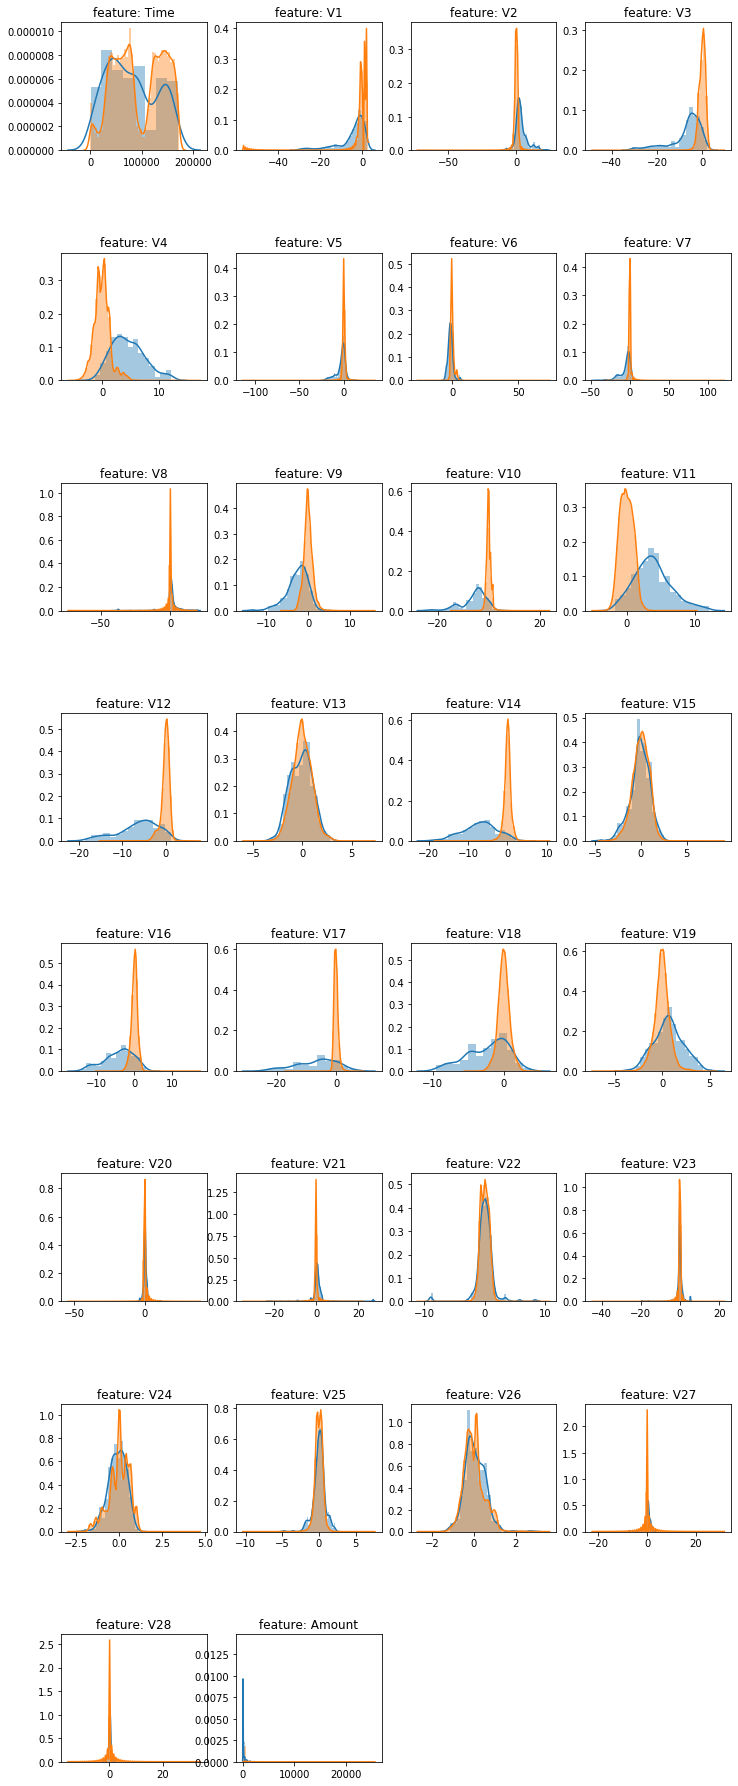

In [9]:
# Representamos gráficamente las características
features = df.drop("Class", axis=1)

plt.figure(figsize=(12,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f][df["Class"] == 1])
    sns.distplot(df[f][df["Class"] == 0])
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

# Observamos a cada uno de los atributos de entrada, de tal manera que se pueda visualizar en cada uno de ellos cada una
# de las clases de la variable de salida. Los legítimos en azul y fraudulentos en naranja.

# Esta gráfica nos sirve para ver que características diferencian bastante bien los elementos positivos de los negativos
# (categorías de la variable respuesta).

# Para la variable Time, podemos observar que los elementos positivos y negativos se encuentran en el mismo rango y con 
# la misma densidad.

# La característica V4 si que va a diferenciar bastante los ejemplos positivos de los negativos, es decir, si que
# diferencia a las clases legítimas y fraudulentas. Entonces puede ser una característica bastante útil para utilizarla
# en diferenciar entre transacciones legítimas y fraudulentas.

# Similar comportamiento vemos en las variables V10, V11, V12, V14, V16 y V17.

### Representación gráfica de dos características:
#### Para graficar usamos las variables V10 y V14, las cuales diferencian bien a los ejemplos fraudulentos de los legítimos.

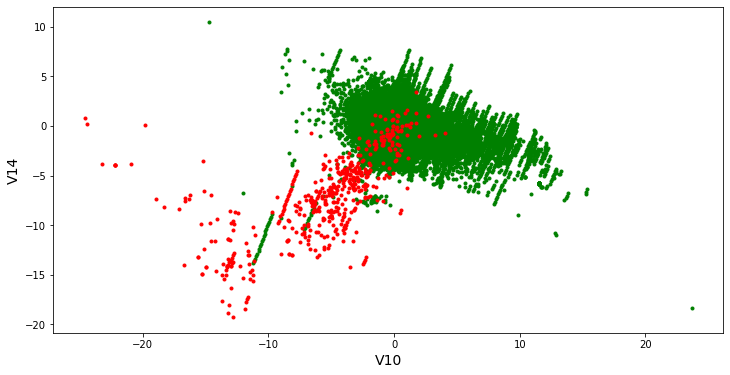

In [10]:
plt.figure(figsize=(12, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

#### ¿Que pasaría si graficamos 2 variables que no diferencian bien a las transacciones fraudulentas de las legítimas?
Observamos que usando las variables V24 y V26 sería muy complicado diferenciar entre ambas categorías, es decir las transacciones legítimas como fraudulentas se aprecian en el mismo rango.

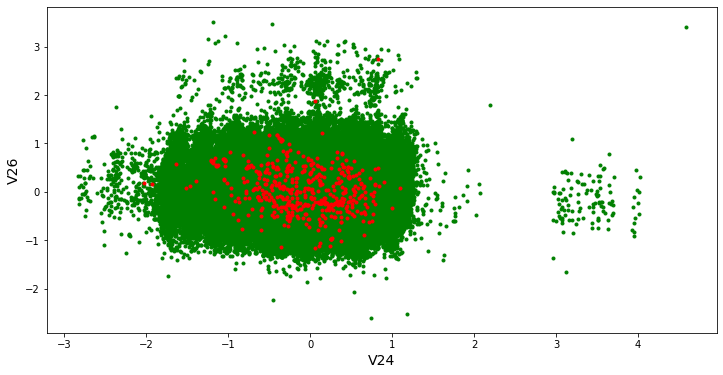

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(df["V24"][df['Class'] == 0], df["V26"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V24"][df['Class'] == 1], df["V26"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V24", fontsize=14)
plt.ylabel("V26", fontsize=14)
plt.show()

**Luego de ganar estas instuiciones sobre nuestras características de manera gráfica, ya podríamos saber que variables pueden ser o no útiles para nuestro algoritmo.**

<h2 style = "color:darkorange">5. Preparación del conjunto de datos</h2> 

Para este tipo de algoritmos es importante que **todos los datos se encuentren en un rango similar, por lo tanto, podemos aplicar una función de escalado o normalización**. 

Otra opción, es eliminar las características que no se encuentran en un rango similar siempre y cuando no sean muy influyentes para la predicción.

In [12]:
# Observando de analizar la representación gráfica de las características de entrada, vemos que las variables "Time" y 
# "Amount" no ayuda a diferenciar las transacciones legítimas de las fraudulentas, manteniendo un rango y densidad similar.
# Entonces eliminamos ambas variables.

df = df.drop(["Time", "Amount"], axis=1)
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0


<h2 style = "color:darkorange">6. Kmeans con un conjunto de datos de dos dimensiones</h2>

**Antes de comenzar con el entrenamiento de KMEANS para todos los atributos del conjunto de datos, se realiza una prueba para dos atributos con el objetivo de comprender como construye el límite de decisión.**

In [14]:
X = df[["V10", "V14"]].copy()
X

,V10,V14
0,0.090794,-0.311169
1,-0.166974,-0.143772
2,0.207643,-0.165946
3,-0.054952,-0.287924
4,0.753074,-1.119670
...,...,...
284802,4.356170,4.626942
284803,-0.975926,-0.675143
284804,-0.484782,-0.510602
284805,-0.399126,0.449624


In [15]:
# Generamos los clusters para nuestro conjunto de datos sin etiquetar

# Para entrenar nuestro algoritmo de clustering, importamos nuestro estimador KMeans de sklearn.cluster.
# Instanciamos la clase KMeans en el objeto "kmeans" definiendo los parámetros n_clusters=5 (numero de clusters) y 
# random_state=42 (semilla aleatoria)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)

# Entrenamos nuestro modelo
clusters = kmeans.fit_predict(X)

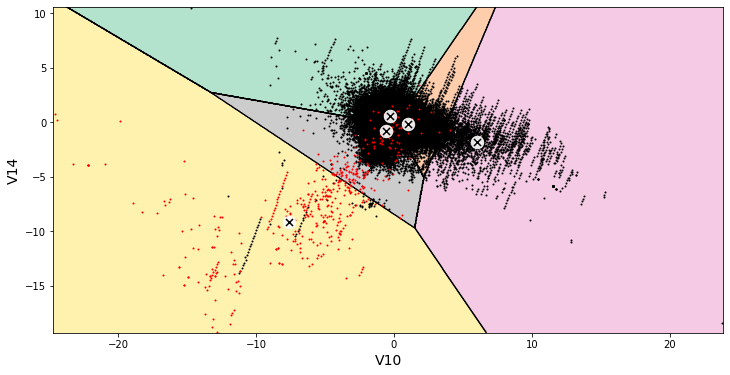

In [16]:
# Visualizando gráficamente los clusters y la distribución de los datos en categorías
plt.figure(figsize=(12, 6))
plot_decision_boundaries(kmeans, X.values, df["Class"].values)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

#### Representación de cada uno de los clústers
Podemos observar la cantidad de elementos que tiene cada cluster y la cantidad de transacciones fraudulentas en cada uno de los clústers.

In [17]:
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[df['Class'] == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

Label 0 has 134343 samples - 15 are malicious samples
Label 1 has 71527 samples - 16 are malicious samples
Label 2 has 2484 samples - 1 are malicious samples
Label 3 has 389 samples - 317 are malicious samples
Label 4 has 76064 samples - 143 are malicious samples


<h2 style = "color:darkorange">7. Kmeans con un conjunto de datos multidimensional</h2>

**Al tratarse de un algoritmo basado en aprendizaje no supervisado, no se requieren las etiquetas para entrenar o predecir. Hay que tener en cuenta que en este tipo de problemas se presupone que no se dispone de las etiquetas.**

In [18]:
# Separamos las características de entrada de la de salida.
X = df.drop("Class", axis=1)
y = df["Class"].copy()

In [20]:
# Entrenamos nuestro algoritmo de KMeans con nuestra data completa
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

In [21]:
# Evaluamos los clusters y el contenido que se han formado
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

Label 0 has 124575 samples - 145 are malicious samples
Label 1 has 107374 samples - 129 are malicious samples
Label 2 has 3562 samples - 12 are malicious samples
Label 3 has 43256 samples - 4 are malicious samples
Label 4 has 6040 samples - 202 are malicious samples


De los resultados anteriores, podemos ver que sin aplicar ningún tipo de métrica de evaluación, este algoritmo se ha comportado peor para nuestro conjunto de datos con todas las características de entrada que para nuestra data con 2 dimensiones.

**KMeans es un algoritmo que se comporta mejor con menos características de entrada.**

<h2 style = "color:darkorange">8. Reducción del número de características</h2>

En muchas ocasiones Kmeans funciona mejor con un número de características bajo.

### Aplicamos selección de características con _Random Forest_

In [22]:
# Utilizamos Random Forest para realizar selección de características
from sklearn.ensemble import RandomForestClassifier

# Entrenamos con 50 árboles aleatorios.
clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [25]:
# Seleccionamos las características más importantes
feature_importances = {name: score for name, score in zip(list(df), clf_rnd.feature_importances_)}
feature_importances

{'V1': 0.015389404971033027,
 'V2': 0.016407150056988305,
 'V3': 0.01722312061737392,
 'V4': 0.02512550413945264,
 'V5': 0.01401712859810283,
 'V6': 0.011296141845450042,
 'V7': 0.02449037051612812,
 'V8': 0.018059564597952896,
 'V9': 0.024722916398008103,
 'V10': 0.06811641427499372,
 'V11': 0.053469614948197276,
 'V12': 0.06888896739850175,
 'V13': 0.010954897237912396,
 'V14': 0.1358320181722068,
 'V15': 0.010922894832491871,
 'V16': 0.08117386226595893,
 'V17': 0.2276567580877801,
 'V18': 0.0421579852578569,
 'V19': 0.013452683786719781,
 'V20': 0.015014336892266172,
 'V21': 0.018718499960898357,
 'V22': 0.009675453221364604,
 'V23': 0.007502442365373689,
 'V24': 0.011850060925530433,
 'V25': 0.011343766053549316,
 'V26': 0.02018126531570017,
 'V27': 0.014577789128218357,
 'V28': 0.011778988133989525}

In [26]:
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted

V17    0.227657
V14    0.135832
V16    0.081174
V12    0.068889
V10    0.068116
V11    0.053470
V18    0.042158
V4     0.025126
V9     0.024723
V7     0.024490
V26    0.020181
V21    0.018718
V8     0.018060
V3     0.017223
V2     0.016407
V1     0.015389
V20    0.015014
V27    0.014578
V5     0.014017
V19    0.013453
V24    0.011850
V28    0.011779
V25    0.011344
V6     0.011296
V13    0.010955
V15    0.010923
V22    0.009675
V23    0.007502
dtype: float64

In [27]:
# Reducimos el conjunto de datos a las 7 características más importantes
X_reduced = X[list(feature_importances_sorted.head(7).index)].copy()
X_reduced

,V17,V14,V16,V12,V10,V11,V18
0,0.207971,-0.311169,-0.470401,-0.617801,0.090794,-0.551600,0.025791
1,-0.114805,-0.143772,0.463917,1.065235,-0.166974,1.612727,-0.183361
2,1.109969,-0.165946,-2.890083,0.066084,0.207643,0.624501,-0.121359
3,-0.684093,-0.287924,-1.059647,0.178228,-0.054952,-0.226487,1.965775
4,-0.237033,-1.119670,-0.451449,0.538196,0.753074,-0.822843,-0.038195
...,...,...,...,...,...,...,...
284802,1.991691,4.626942,1.107641,2.711941,4.356170,-1.593105,0.510632
284803,-0.025693,-0.675143,-0.711757,0.915802,-0.975926,-0.150189,-1.221179
284804,0.313502,-0.510602,0.140716,0.063119,-0.484782,0.411614,0.395652
284805,0.509928,0.449624,-0.608577,-0.962886,-0.399126,-1.933849,1.113981


### Entrenamiento de KMEANS con el conjunto de datos reducido

In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

In [29]:
# Evaluamos los clusters y el contenido que se han formado
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

Label 0 has 20162 samples - 45 are malicious samples
Label 1 has 100980 samples - 90 are malicious samples
Label 2 has 311 samples - 268 are malicious samples
Label 3 has 116590 samples - 69 are malicious samples
Label 4 has 46764 samples - 20 are malicious samples


**Vemos que ha mejorado la capacidad o el rendimiento de predicción cuando se ha hecho la selección de características disminuyendo las características de entrada y tomando las más relevantes para el algoritmo.**

<h2 style = "color:darkorange">9. Evaluación de los resultados</h2> 

Hay que tener cuidado con los **conjuntos de datos desequilibrados** cuando se utilizan métricas para medir la pureza de los clusters.

**Una posible solución es utilizar técnicas de equilibrado del conjunto de datos, como la generación de más ejemplos de transacciones fraudulentas o la disminución de ejemplos de transacciones legítimas.**

In [72]:
# Calculamos el purity score, es importante darse cuenta de que recibe las etiquetas
print("Purity Score:", purity_score(y, clusters))

Purity Score: 0.9990625230419197


In [73]:
# Calculamos el coeficiente de Shiloutte, es importante darse cuenta de que no le pasamos las etiquetas
print("Shiloutte: ", metrics.silhouette_score(X_reduced, clusters, sample_size=10000))

Shiloutte:  0.17631960054515786


In [74]:
# Calculamos el Calinski harabasz score, es importante darse cuenta de que no le pasamos las etiquetas
print("Calinski harabasz: ", metrics.calinski_harabasz_score(X_reduced, clusters))

Calinski harabasz:  40537.024698689966
